#Trabajo Integrador
Primera entrega
##Transmisor
Utiliza la placa Easy dsPIC v7 con un dsPIC30F4013.
Muestrea una señal analógica por la entrada AN2, con frecuencia aproximada de 1 Hz.

Los datos digitalizados se envían por UART hacia una PC transmisora.
Un programa en Python toma los símbolos, realiza la modulación PAM4 y transmite por WiFi (TCP) hacia:

El ESP32 canal, que simula el medio de transmisión.
Una laptop de monitoreo, encargada de visualizar las señales.

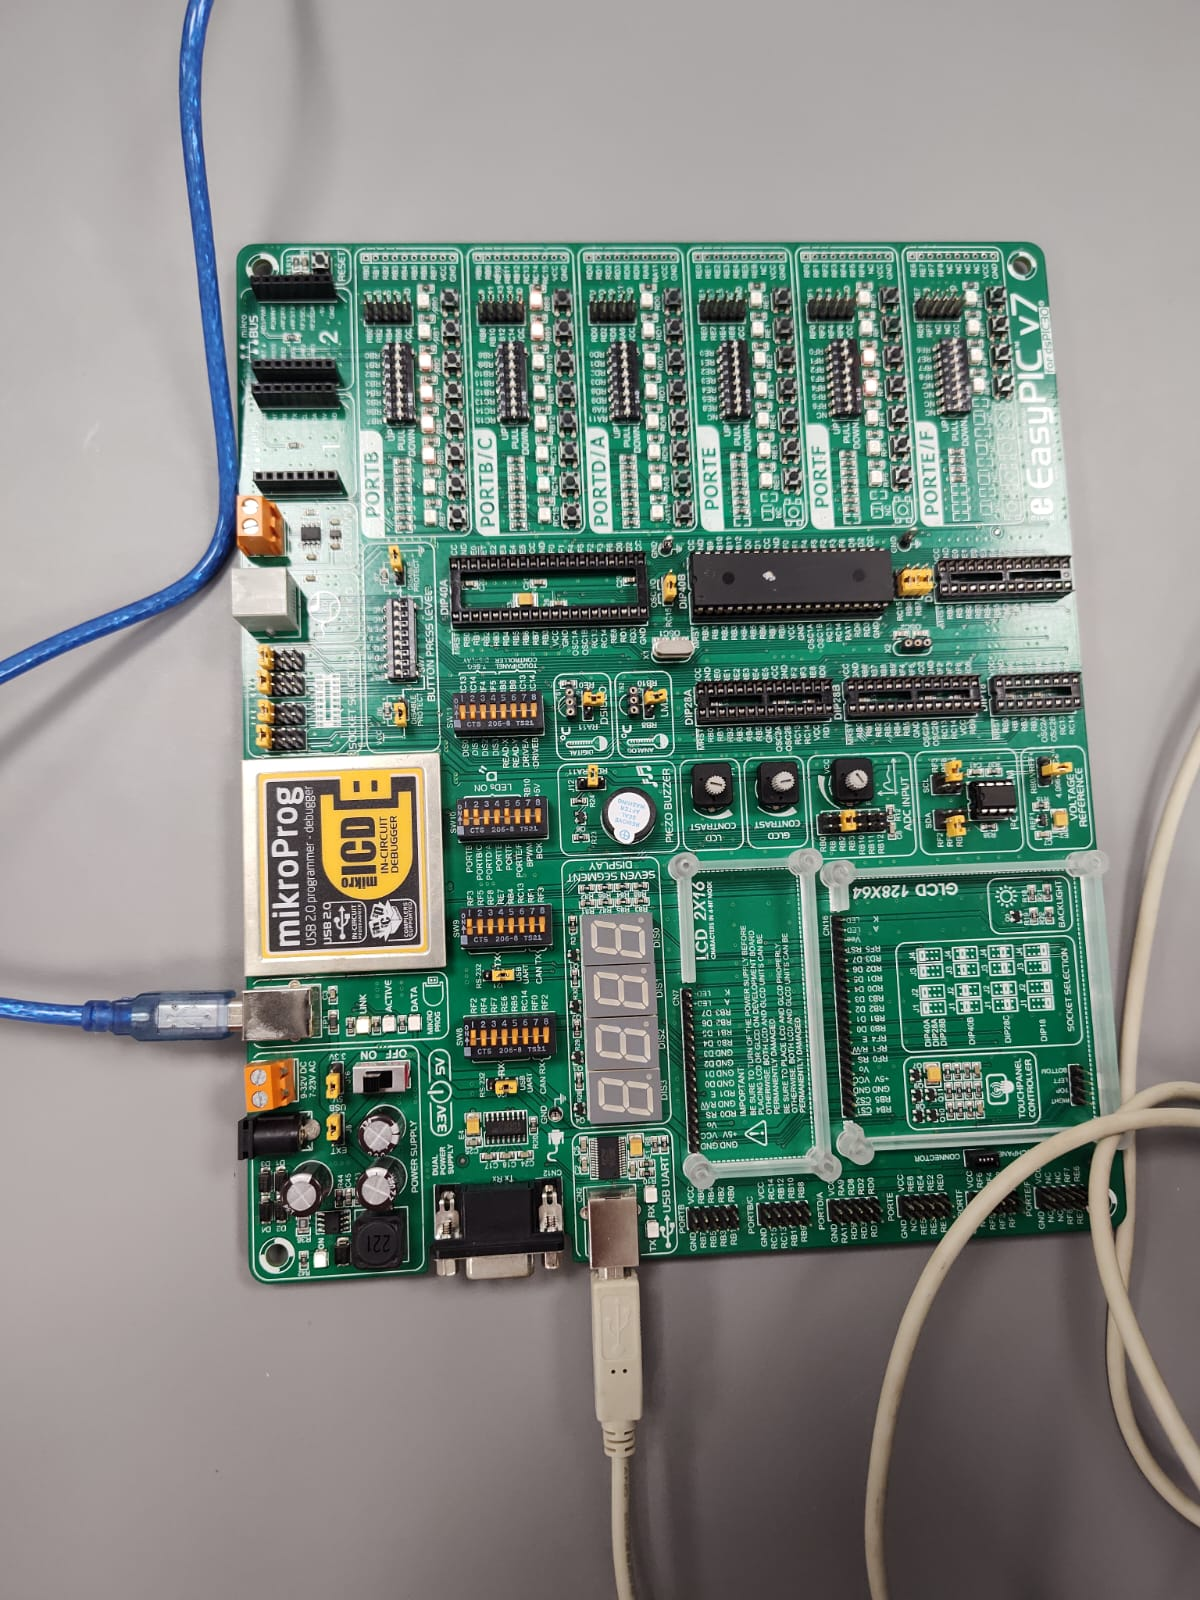

#**Código de la PC**

In [ ]:
#Tx, toma valor Nivel del ADC del DSPIC y lo envía a las IP de canal y de monitoreo cada 1 segundo.
import socket
import sys
import time

try:
    import serial
except Exception:
    class _FallbackSerial:
        def __init__(self, port, baudrate, timeout=1):
            self.port = port
            self.baudrate = baudrate
            self.timeout = timeout
            self._closed = False

        @property
        def in_waiting(self):
            return False

        def read(self, size=1):
            try:
                return sys.stdin.read(size).encode()
            except Exception:
                return b''

        def close(self):
            self._closed = True

    serial = type("serial_module", (), {"Serial": _FallbackSerial})
    print("Warning: pyserial not found; running with stdin fallback.")

def send_pam4_to_destinations(pam4_data, destinos):
    for ip, port in destinos:
        send_pam4(ip, port, pam4_data)

def send_pam4(ip, port, pam4_data):
    try:
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
            s.connect((ip, port))
            s.sendall(bytes(pam4_data))
            print(f"✅ Enviado a {ip}:{port} → {pam4_data}")
    except Exception as e:
        print(f"❌ Error al enviar a {ip}:{port} → {e}")


def valor_a_pam4_symbols(valor):
    # Convertir el valor a 4 bits
    bits = f"{valor:04b}"
    # Separar en dos símbolos PAM4 (2 bits cada uno)
    simbolo1 = int(bits[:2], 2)
    simbolo2 = int(bits[2:], 2)
    return simbolo1, simbolo2

def main():
    puerto_serial = 'COM3'
    baudrate = 9600

    try:
        ser = serial.Serial(puerto_serial, baudrate, timeout=1)
        print(f"🔌 Conectado al puerto {puerto_serial} a {baudrate} baudios.")
    except Exception as e:
        print(f"❌ No se pudo abrir el puerto serial: {e}")
        return

    destinos = [
        ("10.0.0.48", 5051),  # Gonzalo
        # ("10.0.0.52", 5052),  # Candela
        ("10.0.1.255", 8100)  # Eric
    ]

    try:
        while True:
            byte = ser.read(1)
            if byte:
                valor = byte[0]
                if 0 <= valor <= 7:
                    simbolo1, simbolo2 = valor_a_pam4_symbols(valor)
                    print(f"📥 Valor recibido: {valor} → Bits: {valor:04b} → PAM4: [{simbolo1}, {simbolo2}]")
                    send_pam4_to_destinations([simbolo1, simbolo2], destinos)
                else:
                    print(f"⚠️ Valor fuera de rango (0-7): {valor}")
            else:
                print("⚠️ No se recibió ningún dato del puerto serial.")
            time.sleep(0.1)  # Esperar 100 ms
    except KeyboardInterrupt:
        print("🛑 Programa terminado por el usuario.")
    finally:
        ser.close()
if __name__ == "__main__":
    main()

#Descripcion del código:

El código es un script de Python diseñado para leer datos desde un puerto serial, convertirlos en símbolos PAM4 y luego enviar estos símbolos a través de una red a destinos especificados.


##Desglose:

Importar librerías necesarias: Importa socket para la comunicación de red, sys para parámetros y funciones específicas del sistema, time para funciones relacionadas con el tiempo y serial para la comunicación serial. Se incluye un mecanismo de reserva (fallback) si pyserial no está instalado.
Función send_pam4_to_destinations: Esta función toma una lista de datos PAM4 y una lista de pares IP/puerto de destino. Itera a través de los destinos y llama a la función send_pam4 para cada uno.
Función send_pam4: Esta función toma una dirección IP, un puerto y datos PAM4. Crea un socket TCP, se conecta al destino especificado, envía los datos PAM4 e imprime un mensaje de éxito o error.
Función valor_a_pam4_symbols: Esta función convierte un valor de entrada (asumido entre 0 y 7) en dos símbolos PAM4. Lo hace convirtiendo el valor a una cadena binaria de 4 bits y luego dividiéndola en dos símbolos de 2 bits.
Función main: Este es el bloque de ejecución principal.
Define el puerto serial (COM3) y la velocidad en baudios (9600).
Intenta abrir el puerto serial. Si tiene éxito, imprime una confirmación; de lo contrario, imprime un error y sale.
Define una lista de direcciones IP y puertos de destino.
Entra en un bucle while True para leer continuamente datos del puerto serial.

##Dentro del bucle:
Lee un byte del puerto serial.

Si se recibe un byte y su valor está entre 0 y 7, convierte el valor a símbolos PAM4 usando valor_a_pam4_symbols y envía estos símbolos a los destinos definidos usando send_pam4_to_destinations.
Si el valor está fuera del rango 0-7, imprime una advertencia.
Si no se recibe ningún dato, imprime una advertencia.
Espera 100 milisegundos antes de la siguiente lectura.
El bucle puede ser interrumpido por un KeyboardInterrupt (por ejemplo, presionando Ctrl+C).

Finalmente, cierra el puerto serial.

En esencia, este script actúa como un puente entre un dispositivo serial (como un microcontrolador que envía datos de sensores) y múltiples destinos de red, realizando una conversión PAM4 en el medio.

#**Código DSPIC**

In [ ]:
void detectarIntT2() org 0x0020  {
    IFS0bits.T2IF = 0;  // Borrar bandera de interrupción T2

    ADCON1bits.DONE = 0;  // Antes de pedir una muestra ponemos en cero
    ADCON1bits.SAMP = 1;  // Pedimos una muestra

    asm nop;

    ADCON1bits.SAMP = 0;  // Pedimos que retenga la muestra

}

void config_puertos()  {
    // Configurar RB0 como salida
    TRISBbits.TRISB0 = 0;

    TRISBbits.TRISB2 = 1;
    TRISBbits.TRISB3 = 0;
    TRISBbits.TRISB4 = 0;
    TRISBbits.TRISB5 = 0;
    TRISBbits.TRISB6 = 0;
    TRISBbits.TRISB7 = 0;
    TRISBbits.TRISB8 = 0;
    TRISBbits.TRISB9 = 0;
    TRISBbits.TRISB10 = 0;
}



void config_timer2()  {
    // Configurar Timer2
    T2CON = 0x0000;     // Timer apagado, configuración por defecto

    PR2 = 39062;         // Periodo del timer volver 2500

    T2CONbits.TCKPS = 0b10;  // Prescaler 1:1 (0b00)   actual 1:64
    T2CONbits.TON = 1;       // Encender Timer2

    // Habilitar interrupciones
    IEC0bits.T2IE = 1;       // Habilitar interrupción de Timer2
}



void config_adc()  {
    ADPCFG = 0xFFFB; // Elije la entrada analógica a convertir en este caso AN2.
    // Con cero se indica entrada analógica y con 1 sigue siendo entrada digital.

    ADCON1bits.ADON = 0;  // ADC Apagado por ahora
    ADCON1bits.ADSIDL = 1;  // No trabaja en modo idle
    ADCON1bits.FORM = 0b00;  // Formato de salida entero
    // Para tomar muestras en forma manual. Porque lo vamos a controlar con timer2
    ADCON1bits.SSRC = 0b000;
    // Adquiere muestra cuando el SAMP se pone en 1. SAMP lo controlamos desde el Timer2.
    ADCON1bits.ASAM = 0;

    ADCON2bits.VCFG = 0b000;  // Referencia con AVdd y AVss
    ADCON2bits.SMPI = 0b0000;  // Lanza interrupción luego de tomar n muestras.
    // Con SMPI=0b0 -> 1 muestra ; Con SMPI=0b1 -> 2 muestras ; Con SMPI=0b10 -> 3 muestras ; etc.

    // AD1CON3 no se usa ya que tenemos deshabilitado el cálculo del muestreo con ADCS etc.

    // Muestreo la entrada analógica AN2 contra el nivel de AVss (AN0 es S/H+ y AVss es S/H-)
    ADCHS = 0b0010;

    ADCON1bits.ADON = 1;// Habilitamos el A/D
}

void interrupcionADC() org 0x002A {
    unsigned int valorADC = ADCBUF0;
    char txt[6];
    int nivel = valorADC / 512; // 4096 / 512 = 128 por nivel
    LATBbits.LATB0 = !LATBbits.LATB0;

    // Apagar todos los LEDs
    LATBbits.LATB3 = 0;
    LATBbits.LATB4 = 0;
    LATBbits.LATB5 = 0;
    LATBbits.LATB6 = 0;
    LATBbits.LATB7 = 0;
    LATBbits.LATB8 = 0;
    LATBbits.LATB9 = 0;
    LATBbits.LATB10 = 0;

    // Encender según el nivel
    if (nivel >= 1) LATBbits.LATB3 = 1;
    if (nivel >= 2) LATBbits.LATB4 = 1;
    if (nivel >= 3) LATBbits.LATB5 = 1;
    if (nivel >= 4) LATBbits.LATB6 = 1;
    if (nivel >= 5) LATBbits.LATB7 = 1;
    if (nivel >= 6) LATBbits.LATB8 = 1;
    if (nivel >= 7) LATBbits.LATB9 = 1;
    if (nivel >= 8) LATBbits.LATB10 = 1;

    IFS0bits.ADIF = 0; // Borrar bandera de interrupción ADC

    // Enviar valor ADC por UART

   // WordToStr(nivel, txt);
    UART1_Write(nivel);
    //UART1_Write(13);
    //UART1_Write(10);
}


int main() {

    // --- UART1 a 9600 baudios ---
    UART1_Init(9600);            // usa clock del proyecto
    Delay_ms(100);               // breve estabilización

    config_puertos();
    config_timer2();

    // Configuramos el módulo ADC
    config_adc();

    IEC0bits.ADIE = 1;  // Habilitamos interrupción del A/D

    while (1) {
        // Bucle principal vacío, todo se maneja por interrupciones
    }

    return 0;
}